In [ ]:
import ipyleaflet as leaflet
import os
import pyproj
from pyproj.enums import TransformDirection
from pprint import pprint
import ipywidgets as widgets
import morecantile
import geojson
from shapely.geometry import shape, box
import time
import rasterio
import requests
from pathlib import Path
import numpy as np
from rasterio.transform import from_bounds
import rasterio.plot
from PIL import Image
import io
import morecantile

os_api_key = os.environ["OS_API_KEY"]
toOSGB = pyproj.Transformer.from_proj(4326, 27700)

In [2]:
from pyproj.transformer import TransformerGroup

for tg in [TransformerGroup(27700, 4326), TransformerGroup(4326, 27700)]:
    tg.download_grids(verbose=True)

# Parse WMTS GetCapabilities and create TileMatrixSet
import xml.etree.ElementTree as ET

def parse_wmts_tilematrixset(url):
    """Parse WMTS GetCapabilities and extract TileMatrixSet for EPSG:27700"""
    resp = requests.get(url)
    root = ET.fromstring(resp.content)
    
    ns = {'wmts': 'http://www.opengis.net/wmts/1.0', 'ows': 'http://www.opengis.net/ows/1.1'}
    
    for tms_elem in root.findall('.//wmts:TileMatrixSet', ns):
        id_elem = tms_elem.find('ows:Identifier', ns)
        if id_elem is not None and id_elem.text == 'EPSG:27700':
            matrices = []
            for tm in tms_elem.findall('wmts:TileMatrix', ns):
                tm_id = tm.find('ows:Identifier', ns).text.split(':')[-1]  # Get just the number
                scale = float(tm.find('wmts:ScaleDenominator', ns).text)
                topleft = [float(x) for x in tm.find('wmts:TopLeftCorner', ns).text.split()]
                tw = int(tm.find('wmts:TileWidth', ns).text)
                th = int(tm.find('wmts:TileHeight', ns).text)
                mw = int(tm.find('wmts:MatrixWidth', ns).text)
                mh = int(tm.find('wmts:MatrixHeight', ns).text)
                
                matrices.append({
                    'id': tm_id,
                    'scaleDenominator': scale,
                    'cellSize': scale * 0.00028,
                    'pointOfOrigin': topleft,
                    'tileWidth': tw,
                    'tileHeight': th,
                    'matrixWidth': mw,
                    'matrixHeight': mh
                })
            
            return matrices
    
    return None

# Parse the GetCapabilities
getcap_url = f"https://api.os.uk/maps/raster/v1/wmts?service=wmts&request=GetCapabilities&key={os_api_key}"
parsed_matrices = parse_wmts_tilematrixset(getcap_url)

if parsed_matrices:
    print(f"Parsed {len(parsed_matrices)} tile matrices from GetCapabilities")
else:
    print("Failed to parse TileMatrixSet")

Parsed 14 tile matrices from GetCapabilities


In [ ]:
tms = morecantile.TileMatrixSet.model_validate(
    dict(id="EPSG27700", crs="EPSG:27700", tileMatrices=parsed_matrices),
)


def get_tiles_for_bounds(minx, miny, maxx, maxy, zoom):
    """
    Get tile coordinates for a bounding box

    Args:
        minx, miny, maxx, maxy: Bounding box in geographic coordinates
        zoom: Zoom level

    Returns:
        List of morecantile.Tile objects
    """
    tiles = list(tms.tiles(minx, miny, maxx, maxy, zooms=[zoom]))
    return tiles


def get_url_for_tile(tile):
    return f"https://api.os.uk/maps/raster/v1/zxy/Leisure_27700/{tile.z}/{tile.x}/{tile.y}.png?key={os_api_key}"

get_tiles_for_bounds(-3.9185, 56.1504, -3.8672, 56.161, 7)

[Tile(x=289, y=378, z=7),
 Tile(x=290, y=378, z=7),
 Tile(x=291, y=378, z=7),
 Tile(x=289, y=379, z=7),
 Tile(x=290, y=379, z=7),
 Tile(x=291, y=379, z=7)]

In [7]:
out = widgets.Output()

baselayer = leaflet.TileLayer(
    url="https://api.os.uk/maps/raster/v1/zxy/Leisure_27700/{z}/{x}/{y}.png?key="
    + os_api_key,
    min_zoom=1,
    max_zoom=9,
)

leaflet_crs = {
    "name": "EPSG:27700",
    "custom": True,
    "proj4def": "+proj=tmerc +lat_0=49 +lon_0=-2 +k=0.9996012717 +x_0=400000 +y_0=-100000 +ellps=airy +towgs84=446.448,-125.157,542.06,0.15,0.247,0.842,-20.489 +units=m +no_defs",
    "origin": [-238375.0, 1376256.0],
    "bounds": [[-238375.0, 0.0], [900000.0, 1376256.0]],
    "resolutions": [896.0, 448.0, 224.0, 112.0, 56.0, 28.0, 14.0, 7.0, 3.5, 1.75],
}

map = leaflet.Map(
    crs=leaflet_crs,
    min_zoom=baselayer.min_zoom,
    max_zoom=baselayer.max_zoom,
    center=toOSGB.transform(280931, 696954, direction=TransformDirection.INVERSE),
    zoom=7,
)


def save_tiles_as_image(name, coords):
    """Download tiles and stitch them into a GeoTIFF"""

    # Create maps directory if it doesn't exist
    output_dir = Path("maps")
    output_dir.mkdir(exist_ok=True)
    output_path = output_dir / name

    # Convert coords to list for processing
    tile_list = list(coords)

    if len(tile_list) == 0:
        print("No tiles to download")
        return

    assert len(tile_list) < 100

    print(f"Downloading {len(tile_list)} tiles...")

    # Download tiles with rate limiting (50 requests per minute = 1.2s per request)
    tiles_data = {}

    for i, t in enumerate(tile_list):
        url = get_url_for_tile(t)

        try:
            response = requests.get(url, timeout=10)
            response.raise_for_status()

            # Load tile as RGB image (convert if necessary)
            img = Image.open(io.BytesIO(response.content))
            if img.mode != "RGB":
                img = img.convert("RGB")
            tiles_data[(t.x, t.y, t.z)] = np.array(img)

            # Rate limiting: 50 requests per minute
            if i < len(tile_list) - 1:  # Don't wait after the last tile
                time.sleep(1.2)

            if (i + 1) % 10 == 0:
                print(f"Downloaded {i + 1}/{len(tile_list)} tiles")

        except Exception as e:
            print(f"Error downloading tile {t.x}, {t.y}, {t.z}: {e}")

    if not tiles_data:
        print("No tiles downloaded successfully")
        return

    # Determine the bounds and size of the mosaic
    xs = [x for x, y, z in tiles_data.keys()]
    ys = [y for x, y, z in tiles_data.keys()]
    z = tile_list[0].z  # All tiles should have the same zoom level

    min_x, max_x = min(xs), max(xs)
    min_y, max_y = min(ys), max(ys)

    # Get tile size from first tile
    first_tile = next(iter(tiles_data.values()))
    tile_height, tile_width = first_tile.shape[:2]
    n_bands = first_tile.shape[2]  # Should be 3 for RGB

    # Create mosaic array
    mosaic_width = (max_x - min_x + 1) * tile_width
    mosaic_height = (max_y - min_y + 1) * tile_height
    mosaic = np.zeros((mosaic_height, mosaic_width, n_bands), dtype=first_tile.dtype)

    # Place tiles in mosaic
    for (x, y, z), tile_data in tiles_data.items():
        x_offset = (x - min_x) * tile_width
        y_offset = (y - min_y) * tile_height
        mosaic[y_offset : y_offset + tile_height, x_offset : x_offset + tile_width] = (
            tile_data
        )

    # Calculate geographic bounds for the mosaic using morecantile
    ul_tile = morecantile.Tile(min_x, min_y, z)
    lr_tile = morecantile.Tile(max_x + 1, max_y + 1, z)

    ul_bounds = tms.xy_bounds(ul_tile)
    lr_bounds = tms.xy_bounds(lr_tile)

    west = ul_bounds.left
    north = ul_bounds.top
    east = lr_bounds.right
    south = lr_bounds.bottom

    # Transpose from (H, W, C) to (C, H, W) for rasterio
    mosaic = np.transpose(mosaic, (2, 0, 1))

    with rasterio.open(
        output_path,
        "w",
        driver="GTiff",
        height=mosaic_height,
        width=mosaic_width,
        count=n_bands,
        dtype=mosaic.dtype,
        crs="EPSG:27700",
        transform=from_bounds(west, south, east, north, mosaic_width, mosaic_height),
        compress="lzw",
        photometric="RGB",
    ) as dst:
        dst.write(mosaic)

    print(f"Saved to {output_path}")


filename_input = widgets.Text(
    value="", placeholder="Enter filename", description="Filename:", disabled=False
)
download_button = widgets.Button(
    description="Download", disabled=True, button_style="primary"
)

current_bounds = None


def on_map_draw(control, action, geo_json):
    global current_bounds
    with out:
        bounds = shape(geo_json).bounds
        current_bounds = bounds
        print(f"SELECTED BOUNDS (WGS84): {bounds}")
        download_button.disabled = False


def on_download(b):
    global current_bounds
    with out:
        name = filename_input.value
        if name == "":
            print("Please enter a filename")
            return

        if current_bounds is None:
            print("Please select an area on the map first")
            return

        # Bounds are in WGS84 (lon, lat), need to convert to EPSG:27700
        (minx, miny, maxx, maxy) = current_bounds

        for zname, z in [("landranger", 7), ("explorer", 9)]:
            # Use morecantile to get tiles that intersect the bounding box
            tiles = get_tiles_for_bounds(minx, miny, maxx, maxy, z)
            print(f"Found {len(tiles)} tiles for {zname} (zoom {z})")
            save_tiles_as_image(f"{name}_{zname}.tif", tiles)


download_button.on_click(on_download)

draw_control = leaflet.DrawControl(polygon={"shapeOptions": {"#0000FF"}})
draw_control.on_draw(on_map_draw)

map.layout.height = "600px"
map.add(draw_control)
map.add(baselayer)

# Create the layout with input/button row at top and map below
control_row = widgets.HBox([filename_input, download_button])
ui = widgets.VBox([control_row, map])

with out:
    display(ui)

out

Output()

Found 2 GeoTIFF(s):

dumyat_landranger.tif:
  CRS: EPSG:27700
  Bounds: BoundingBox(left=279512.9999184428, bottom=693504.00010752, right=286680.99991731404, top=698880.0001066735)
  Size: 768 x 512
  Bands: 3


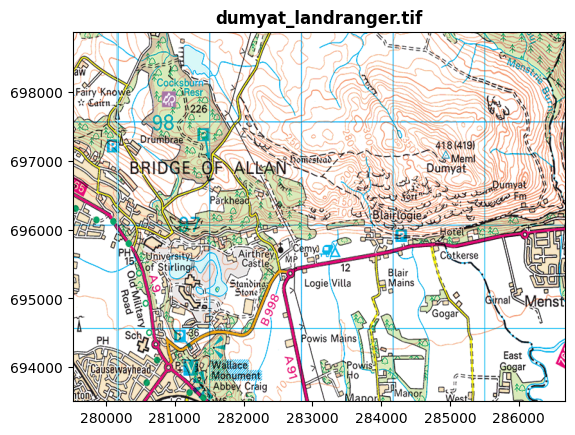


dumyat_explorer.tif:
  CRS: EPSG:27700
  Bounds: BoundingBox(left=280856.99991823116, bottom=696192.0001070967, right=284440.9999176667, top=698432.000106744)
  Size: 1792 x 1024
  Bands: 3


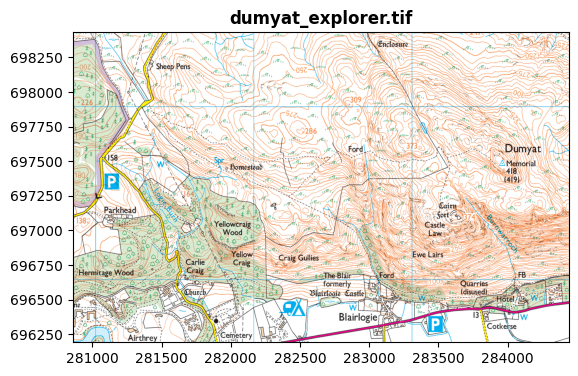

In [8]:
maps_dir = Path("maps")
max_displayed = 3
if maps_dir.exists():
    geotiffs = list(maps_dir.glob("*.tif"))
    
    if geotiffs:
        print(f"Found {len(geotiffs)} GeoTIFF(s):")
        for tif in geotiffs[:max_displayed]:
            print(f"\n{tif.name}:")
            with rasterio.open(tif) as src:
                print(f"  CRS: {src.crs}")
                print(f"  Bounds: {src.bounds}")
                print(f"  Size: {src.width} x {src.height}")
                print(f"  Bands: {src.count}")
                rasterio.plot.show(src, title=tif.name)
        
        if len(geotiffs) > max_displayed:
            print("...")
    else:
        print("No GeoTIFF files found in maps/")
else:
    print("maps/ directory doesn't exist yet")
    